Opening the Data Sources

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns
import zipfile
import sqlite3

In [2]:
movie_gross_data = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
movie_gross_data["foreign_gross"].fillna(0, inplace = True)
movie_gross_data["domestic_gross"].fillna(0, inplace = True)
movie_gross_data.dropna(inplace = True)
movie_gross_data.drop_duplicates(subset=["title"], inplace=True)

In [3]:
movie_gross_data["domestic_gross"].replace(',','', regex = True, inplace = True)
movie_gross_data["foreign_gross"].replace(',','', regex = True, inplace = True)
movie_gross_data["foreign_gross"] = movie_gross_data["foreign_gross"].astype(float)
movie_gross_data["domestic_gross"] = movie_gross_data["domestic_gross"].astype(float)

In [4]:
movie_gross_data["total_gross"] = movie_gross_data["foreign_gross"].astype(float) + movie_gross_data["domestic_gross"].astype(float)

In [5]:
movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
movie_budgets.drop_duplicates(subset=["movie"], inplace=True)

In [6]:
movie_budgets.production_budget.replace(",","",regex=True, inplace=True)
movie_budgets.domestic_gross.replace(",","",regex=True, inplace=True)
movie_budgets.worldwide_gross.replace(",","",regex=True, inplace=True)

In [7]:
movie_budgets["production_budget"] = movie_budgets.production_budget.str.strip("$")
movie_budgets["domestic_gross"] = movie_budgets.domestic_gross.str.strip("$")
movie_budgets["worldwide_gross"] = movie_budgets.worldwide_gross.str.strip("$")

In [8]:
movie_budgets["production_budget"] = movie_budgets.production_budget.astype(float)
movie_budgets["domestic_gross"] = movie_budgets.domestic_gross.astype(float)
movie_budgets["worldwide_gross"] = movie_budgets.worldwide_gross.astype(float)

In [9]:
movie_budgets["profit_or_loss"] = movie_budgets.worldwide_gross - movie_budgets.production_budget
movie_budgets["relation_pro_los"] = movie_budgets.worldwide_gross/movie_budgets.production_budget

In [10]:
with zipfile.ZipFile("zippedData/im.db.zip", "r") as zObject:
        zObject.extractall()

In [11]:
conn = sqlite3.connect("im.db")
cur = conn.cursor()

In [12]:
query_for_high_ratings = """
SELECT averagerating as avg_rating, genres, numvotes
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
WHERE averagerating >= 8.5
AND numvotes > 30
AND genres IS NOT NULL
ORDER BY avg_rating DESC
;
"""
high_ratings = pd.read_sql(query_for_high_ratings, conn)

In [13]:
high_ratings = high_ratings[high_ratings["genres"].str.contains("None") == False]
data_for_analysis_by_rating_high = high_ratings.groupby(by="genres", as_index=False).mean()
data_for_analysis_by_rating_high.sort_values(by="avg_rating", ascending=False, inplace = True)

In [14]:
query_for_low_ratings = """
SELECT averagerating as avg_rating, genres, numvotes
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
WHERE averagerating <= 2
AND numvotes > 30
AND genres IS NOT NULL
GROUP BY genres
ORDER BY avg_rating DESC
;
"""
low_ratings = pd.read_sql(query_for_low_ratings, conn)

In [15]:
low_ratings = low_ratings[low_ratings["genres"].str.contains("None") == False]
data_for_analysis_by_rating_low = low_ratings.groupby(by="genres", as_index=False).mean()
data_for_analysis_by_rating_low.sort_values(by="avg_rating", ascending=True, inplace = True)

In [16]:
query_for_genre = '''
    SELECT
        movie_id AS "ID",
        primary_title AS "Title",
        original_title AS "Original Title",
        genres AS "Genres"
    FROM movie_basics
        JOIN movie_ratings
        USING (movie_id)
'''
movie_by_genre = pd.read_sql(query_for_genre,conn)

In [17]:
movie_by_genre.drop_duplicates(subset=["Title"], inplace=True)
movie_by_genre.drop_duplicates(subset=["Original Title"], inplace = True)
movie_by_genre = movie_by_genre[movie_by_genre.Genres.str.contains("None") == False]

In [18]:
gross_and_genre = pd.merge(movie_budgets, movie_by_genre, how="inner", left_on="movie", right_on="Title")

In [19]:
del gross_and_genre["Title"]
del gross_and_genre["Original Title"]
del gross_and_genre["id"]
del gross_and_genre["release_date"]

In [20]:
top_20_by_rating = data_for_analysis_by_rating_high.iloc[:20]
top_20__by_rating_no_numvotes = top_20_by_rating.drop(["numvotes"], axis = 1)

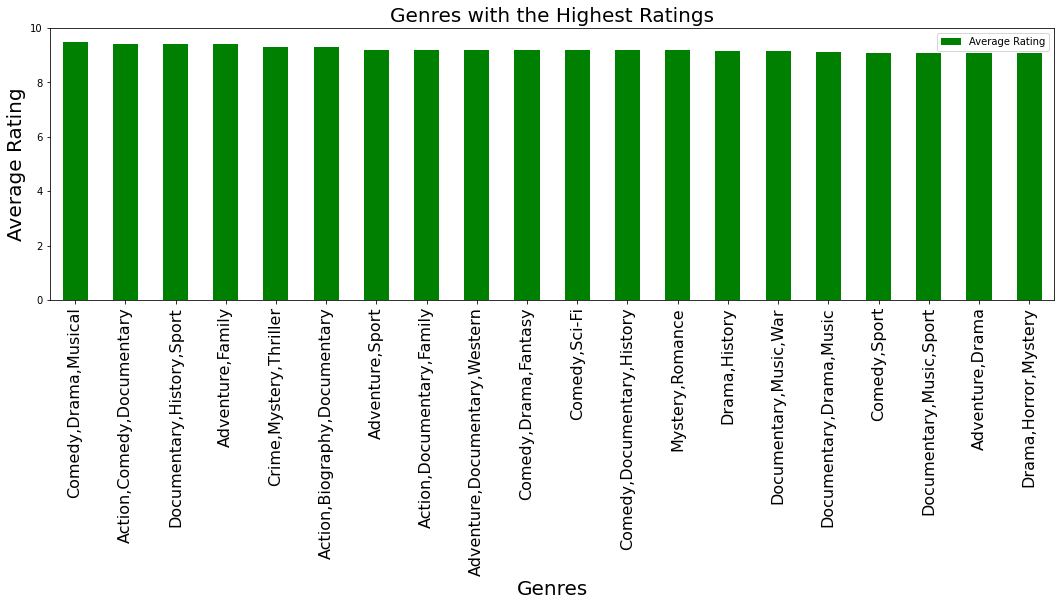

In [21]:
top_20__by_rating_no_numvotes.plot("genres", kind="bar", figsize = (18,5), color = "g")
plt.xlabel("Genres", fontsize = 20)
plt.xticks(rotation = 90, fontsize = 16)
plt.ylabel("Average Rating", fontsize = 20)
plt.yticks(range(0,11,2))
plt.title("Genres with the Highest Ratings", fontsize = 20)
plt.legend(labels=['Average Rating'])
plt.show()

In [22]:
top_20_low_by_rating = data_for_analysis_by_rating_low.iloc[:20]
top_20_low_by_rating_no_numvotes = top_20_low_by_rating.drop(["numvotes"], axis = 1)

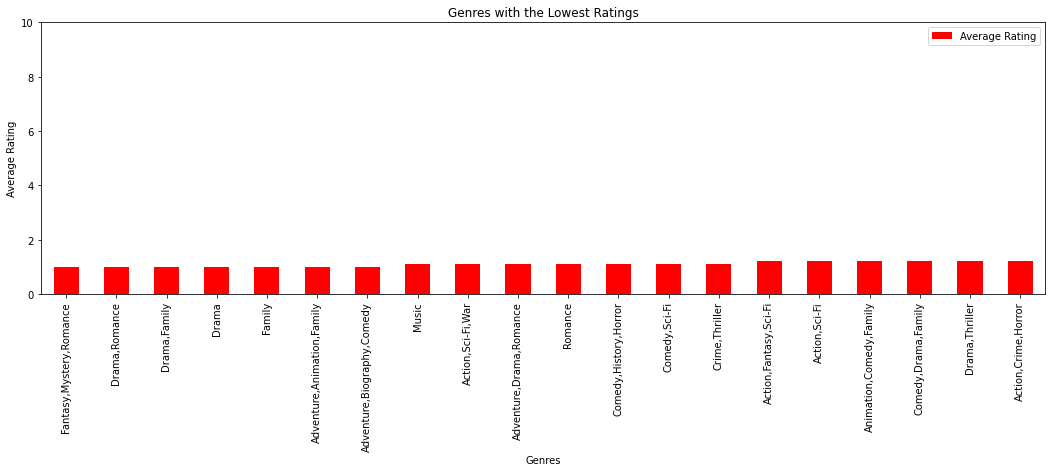

In [23]:
top_20_low_by_rating_no_numvotes.plot("genres", kind="bar", figsize = (18,5), color = "r")
plt.xlabel("Genres")
plt.xticks(rotation = 90)
plt.ylabel("Average Rating")
plt.yticks(range(0,11,2))
plt.title("Genres with the Lowest Ratings")
plt.legend(labels=['Average Rating'])
plt.show()

In [24]:
movie_domestic_foreign_comparison = movie_gross_data[movie_gross_data["foreign_gross"] != 0]
movie_domestic_foreign_comp_comparison = movie_domestic_foreign_comparison[movie_domestic_foreign_comparison["domestic_gross"] != 0]

In [25]:
merged_imdb_domestic_and_foreign = pd.merge(movie_by_genre, movie_domestic_foreign_comparison, how = "inner", left_on= "Title", right_on= "title")

In [26]:
data_for_analysis_by_gross = merged_imdb_domestic_and_foreign[["Genres",'domestic_gross','foreign_gross','total_gross']]

In [27]:
data_for_analysis_by_genre = data_for_analysis_by_gross.groupby(by="Genres", as_index=False).sum()
data_for_analysis_by_genre.sort_values(by="total_gross", ascending=False, inplace = True)

In [28]:
data_for_analysis_by_genre_total = data_for_analysis_by_genre.groupby(by="Genres", as_index=False).sum()
data_for_analysis_by_genre_total.sort_values(by="total_gross", ascending=False, inplace = True)

In [29]:
data_for_analysis_by_genre_total.drop(["domestic_gross"], axis = 1, inplace = True)
data_for_analysis_by_genre_total.drop(["foreign_gross"], axis = 1, inplace = True)

In [30]:
data_for_analysis_by_genre.drop(["total_gross"], axis = 1, inplace = True)

In [31]:
top_20_by_genre = data_for_analysis_by_genre.iloc[:20]
bottom_20_by_genre = data_for_analysis_by_genre.iloc[-20:]
top_20_gross_by_genre = data_for_analysis_by_genre_total.iloc[:20]

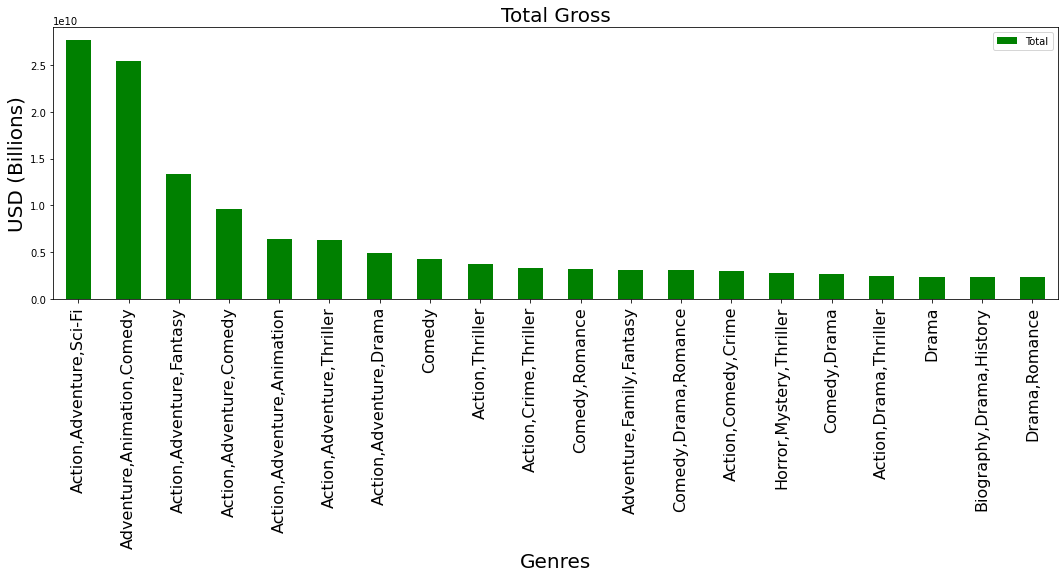

In [32]:
top_20_gross_by_genre.plot("Genres", kind="bar", figsize = (18,5), color = "g")
plt.xlabel("Genres" , fontsize = 20)
plt.xticks(rotation = 90, fontsize = 16)
plt.ylabel("USD (Billions)", fontsize = 20)
plt.title("Total Gross", fontsize = 20)
plt.legend(labels=['Total'])
plt.show()

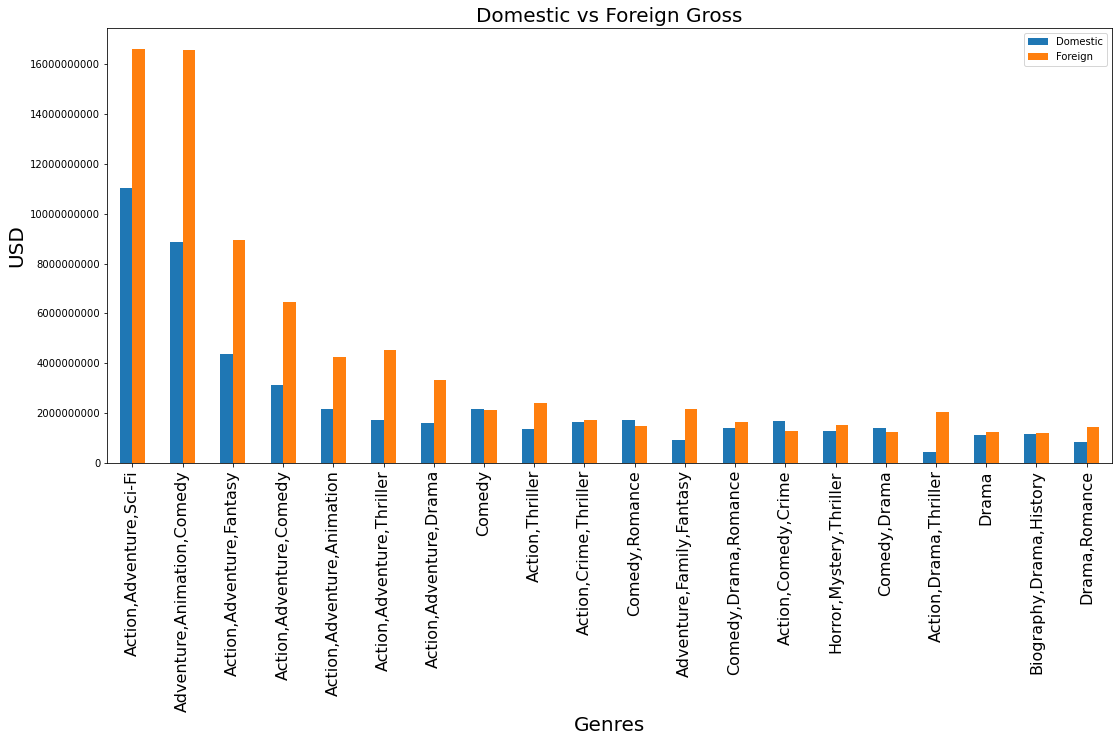

In [33]:
top_20_by_genre.plot("Genres", kind="bar", figsize = (18,8))
plt.xlabel("Genres", fontsize = 20)
plt.xticks(rotation = 90, fontsize = 16)
plt.ylabel("USD", fontsize = 20)
plt.ticklabel_format(style="plain", axis="y")
plt.title("Domestic vs Foreign Gross", fontsize = 20)
plt.legend(labels=['Domestic', 'Foreign'])
plt.draw()

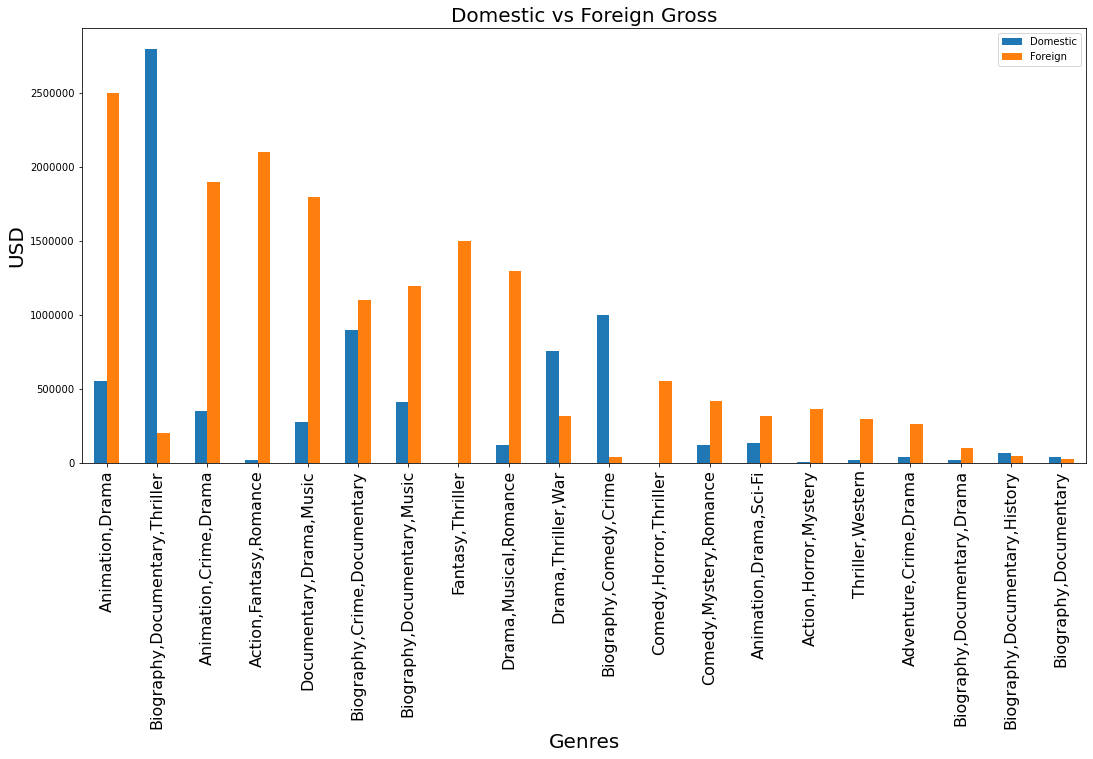

In [34]:
bottom_20_by_genre.plot("Genres", kind="bar", figsize = (18,8))
plt.xlabel("Genres", fontsize = 20)
plt.xticks(rotation = 90, fontsize = 16)
plt.ylabel("USD", fontsize = 20)
plt.ticklabel_format(style="plain", axis="y")
plt.title("Domestic vs Foreign Gross", fontsize = 20)
plt.legend(labels=['Domestic', 'Foreign'])
plt.show()

In [35]:
genre_gross_grouped = gross_and_genre.groupby(by="Genres", as_index=False).sum()
genre_gross_grouped["relation_pro_los"] = genre_gross_grouped.worldwide_gross/genre_gross_grouped.production_budget
genre_gross_top = genre_gross_grouped.sort_values(by="profit_or_loss", ascending=False).iloc[:20]
genre_gross_bottom = genre_gross_grouped.sort_values(by="profit_or_loss").iloc[:20]
genre_gross_bottom = genre_gross_grouped.sort_values(by="profit_or_loss").iloc[:(20+1)]
genre_gross_bottom.drop(index=32, inplace=True)

In [36]:
f1 = 15
f2 = 15 
hs = 3
fx = 16
fy = 16
ft = 20

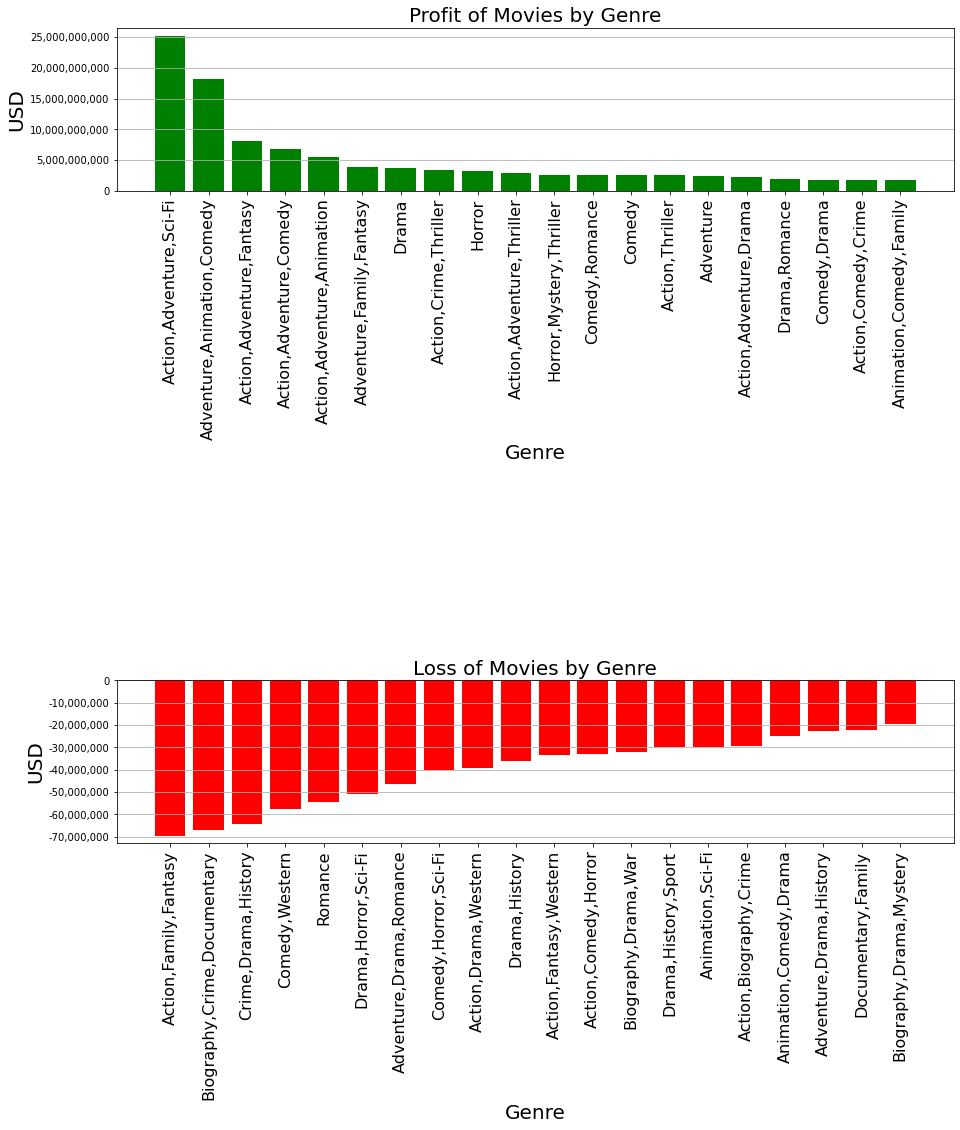

In [37]:
fig, (ax1, ax2) = plt.subplots(figsize=(f1,f2), nrows=2, ncols=1)

ax1.bar(genre_gross_top.Genres, genre_gross_top.profit_or_loss, color="g")

ax1.set_title("Profit of Movies by Genre", fontdict={"fontsize":ft})

plt.draw()
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontdict={"fontsize":fx})

ax1.ticklabel_format(style="plain", axis="y")
ax1.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.set_xlabel("Genre", fontdict={"fontsize":ft})
ax1.set_ylabel("USD", fontdict={"fontsize":ft})
ax1.grid(axis="y")

#######

ax2.bar(genre_gross_bottom.Genres, genre_gross_bottom.profit_or_loss, color="r")
ax2.set_title("Loss of Movies by Genre", fontdict={"fontsize":ft})

plt.draw()
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontdict={"fontsize":fx})
ax2.ticklabel_format(style="plain", axis="y")
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.set_xlabel("Genre", fontdict={"fontsize":ft})
ax2.set_ylabel("USD", fontdict={"fontsize":ft})
ax2.grid(axis="y")

#######

plt.subplots_adjust(hspace=hs)
plt.show()

In [38]:
wwg_top = genre_gross_top.sort_values(by="worldwide_gross", ascending=False)
wwg_bottom = genre_gross_bottom.sort_values(by="worldwide_gross", ascending=False)

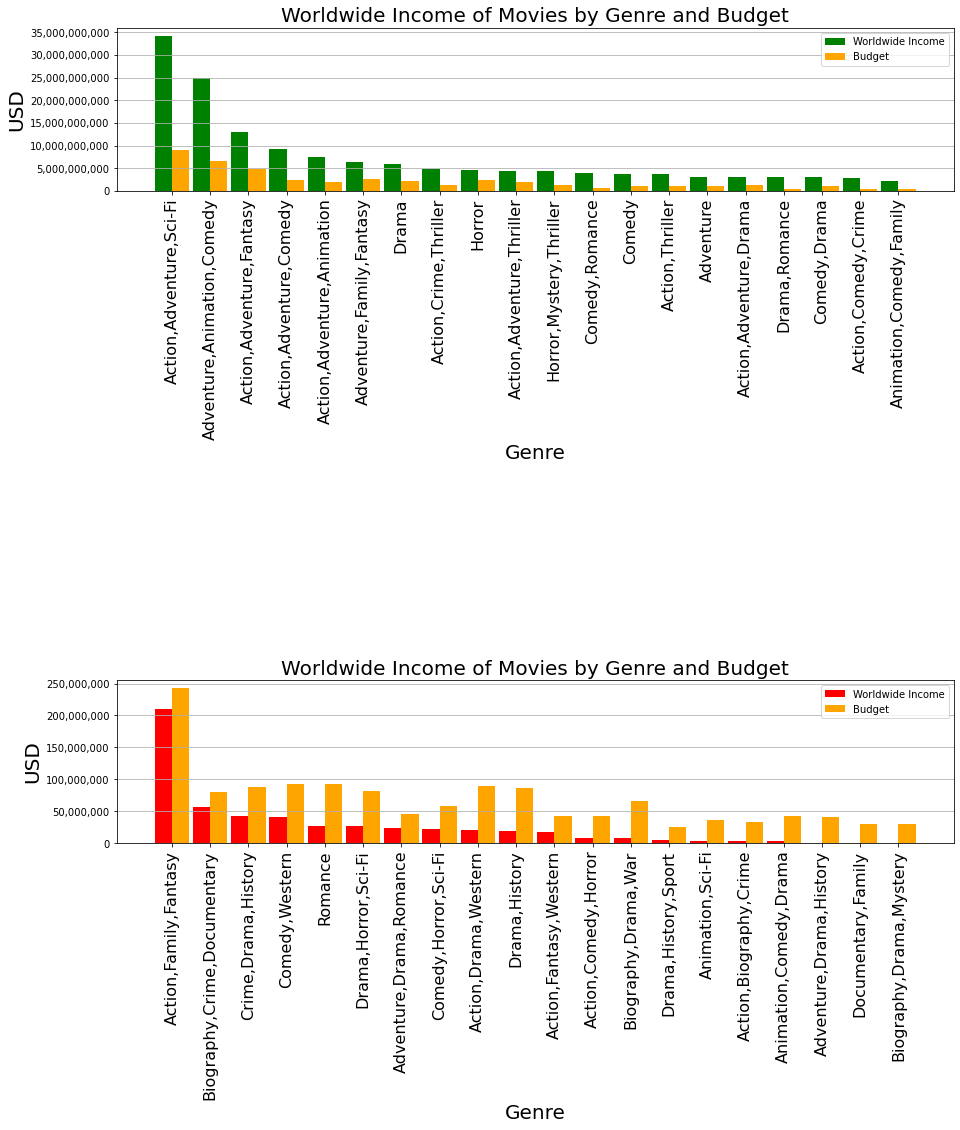

In [39]:
fig, (ax1, ax2) = plt.subplots(figsize=(f1,f2), nrows=2, ncols=1)

ax1.bar(genre_gross_top.Genres, wwg_top.worldwide_gross, width=-0.45, color="g", align="edge")
ax1.bar(genre_gross_top.Genres, wwg_top.production_budget, width=0.45, color="orange", align="edge")

ax1.set_title("Worldwide Income of Movies by Genre and Budget", fontdict={"fontsize":ft})


plt.draw()
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontdict={"fontsize":fx})
ax1.ticklabel_format(style="plain", axis="y")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


ax1.set_xlabel("Genre", fontdict={"fontsize":ft})
ax1.set_ylabel("USD", fontdict={"fontsize":ft})
ax1.legend(labels=['Worldwide Income', 'Budget'])

ax1.grid(axis="y")

#######

ax2.bar(genre_gross_bottom.Genres, wwg_bottom.worldwide_gross, width=-0.45, color="r",align="edge")
ax2.bar(genre_gross_bottom.Genres, wwg_bottom.production_budget, width=0.45, color="orange", align="edge")

ax2.set_title("Worldwide Income of Movies by Genre and Budget", fontdict={"fontsize":ft})

plt.draw()
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontdict={"fontsize":fx})
ax2.ticklabel_format(style="plain", axis="y")
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.set_xlabel("Genre", fontdict={"fontsize":ft})
ax2.set_ylabel("USD", fontdict={"fontsize":ft})
ax2.legend(labels=['Worldwide Income', 'Budget'])

ax2.grid(axis="y")

#######
plt.subplots_adjust(hspace=hs)
plt.show()

In [40]:
relation_top = genre_gross_top.sort_values(by="relation_pro_los", ascending=False)
relation_bottom = genre_gross_bottom.sort_values(by="relation_pro_los", ascending=False)

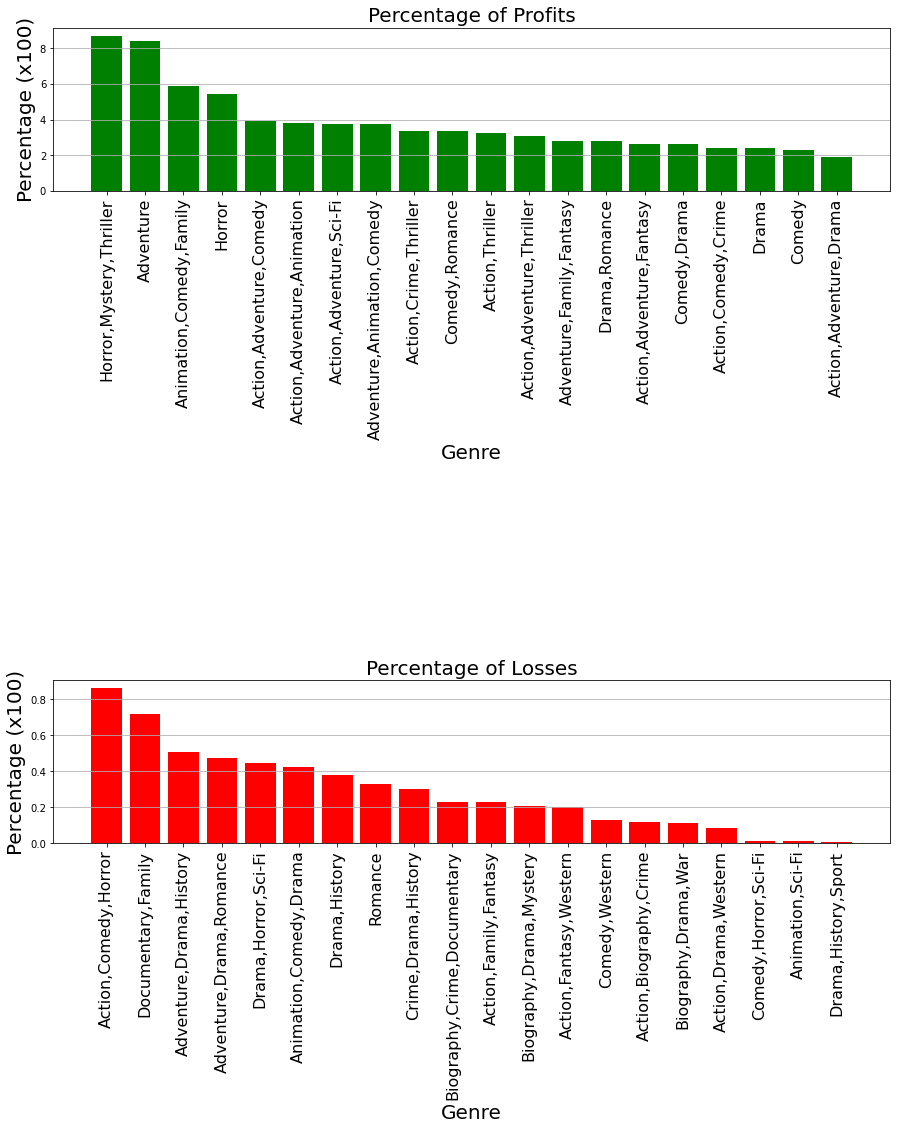

In [41]:
fig, (ax1, ax2) = plt.subplots(figsize=(f1,f2), nrows=2, ncols=1)

ax1.bar(relation_top.Genres, relation_top.relation_pro_los, color="g")

ax1.set_title("Percentage of Profits", fontdict={"fontsize":ft})

plt.draw()
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontdict={"fontsize":fx})

ax1.set_xlabel("Genre", fontdict={"fontsize":ft})
ax1.set_ylabel("Percentage (x100)", fontdict={"fontsize":ft})
ax1.grid(axis="y")

#######

ax2.bar(relation_bottom.Genres, relation_bottom.relation_pro_los, color="r")
ax2.set_title("Percentage of Losses", fontdict={"fontsize":ft})

plt.draw()
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontdict={"fontsize":fx})

ax2.set_xlabel("Genre", fontdict={"fontsize":ft})
ax2.set_ylabel("Percentage (x100)", fontdict={"fontsize":ft})
ax2.grid(axis="y")

#######

plt.subplots_adjust(hspace=hs)
plt.show()

In [42]:
genre_gross_mean = gross_and_genre.copy()

In [43]:
del genre_gross_mean["movie"]
del genre_gross_mean["production_budget"]
del genre_gross_mean["domestic_gross"]
del genre_gross_mean["worldwide_gross"]
del genre_gross_mean["profit_or_loss"]
del genre_gross_mean["ID"]

In [44]:
genre_gross_mean = genre_gross_mean.groupby(by="Genres", as_index=False).mean()

In [45]:
pop_mean = genre_gross_mean.relation_pro_los.mean()
pop_std  = genre_gross_mean.relation_pro_los.std()

In [46]:
sample_genres = genre_gross_mean.sample(n=100)

In [47]:
sample_mean = sample_genres.relation_pro_los.mean()
sample_std  = sample_genres.relation_pro_los.std()
sample_size = sample_genres.shape[0]
se = np.std(sample_genres.relation_pro_los) / np.sqrt(sample_size)
alpha = 0.05

In [48]:
z = (sample_mean-pop_mean) / (pop_std/np.sqrt(sample_size))
z

-0.05641471207228743

In [49]:
if z<0:
    p = stats.norm.cdf(z)
elif (z>0) & (z<0.1):
    p = 2 * (1 - stats.norm.cdf(abs(z)))
else:
    p = 1 - stats.norm.cdf(z)

p

0.47750571854076457

Mean:  3.2362013867424766 
STD:   4.877048890427193


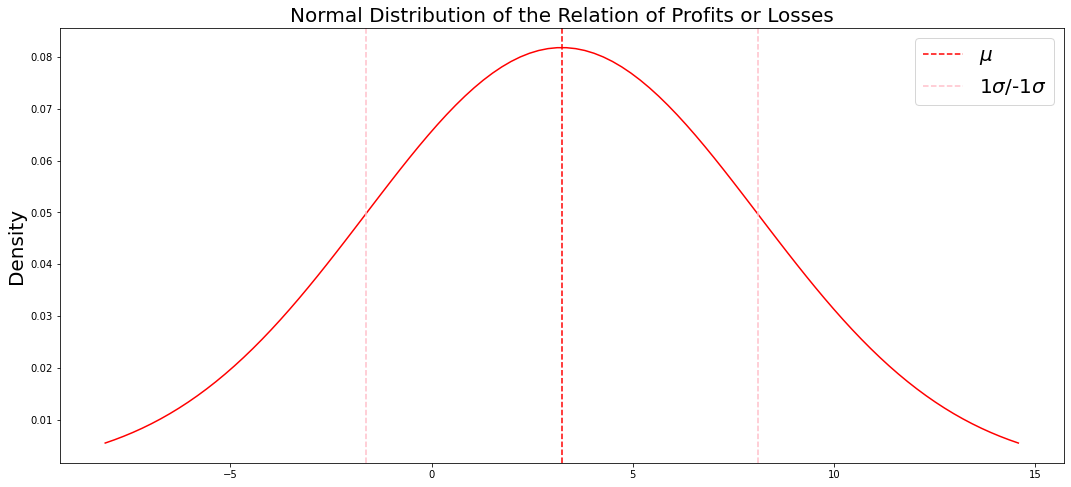

In [50]:
fig, ax = plt.subplots(figsize=(18,8))

x = np.linspace(
        stats.norm(sample_mean, sample_std).ppf(0.01), # Start plotting here
        stats.norm(sample_mean, sample_std).ppf(0.99), # End plotting here
        100                                      # Number of points
)

y = stats.norm(sample_mean,sample_std).pdf(x)

ax.plot(x, y,'r-')

#Reference values
plt.axvline(x=sample_mean, color="r", label="$\mu$", linestyle="--")                               #Mean
plt.axvline(x=sample_std+sample_mean, color="pink", linestyle="--", label="1$\sigma$/-1$\sigma$")  #1 STD
plt.axvline(x=-sample_std+sample_mean, color="pink", linestyle="--")                               #-1 STD

#Graph labels
plt.legend(prop={'size': 20})
ax.set_ylabel("Density", fontdict={"fontsize":ft})
ax.set_title("Normal Distribution of the Relation of Profits or Losses", fontdict={"fontsize": 20});

print("Mean: ", sample_mean, "\nSTD:  ", sample_std)

In [52]:
merged_gross_budget_and_genre = pd.merge(movie_gross_data, movie_budgets, how = "inner", left_on= "title", right_on= "movie")


In [53]:
merged_gross_budget_and_genre.drop_duplicates(subset=["studio"], inplace=True)

In [54]:
merged_gross_budget_and_genre_for_analysis = merged_gross_budget_and_genre[["studio","profit_or_loss",]]

In [55]:
top_20_by_studio = merged_gross_budget_and_genre_for_analysis[["studio","profit_or_loss"]].iloc[:20]
top_20_by_studio.sort_values(by="profit_or_loss", ascending=False, inplace = True)

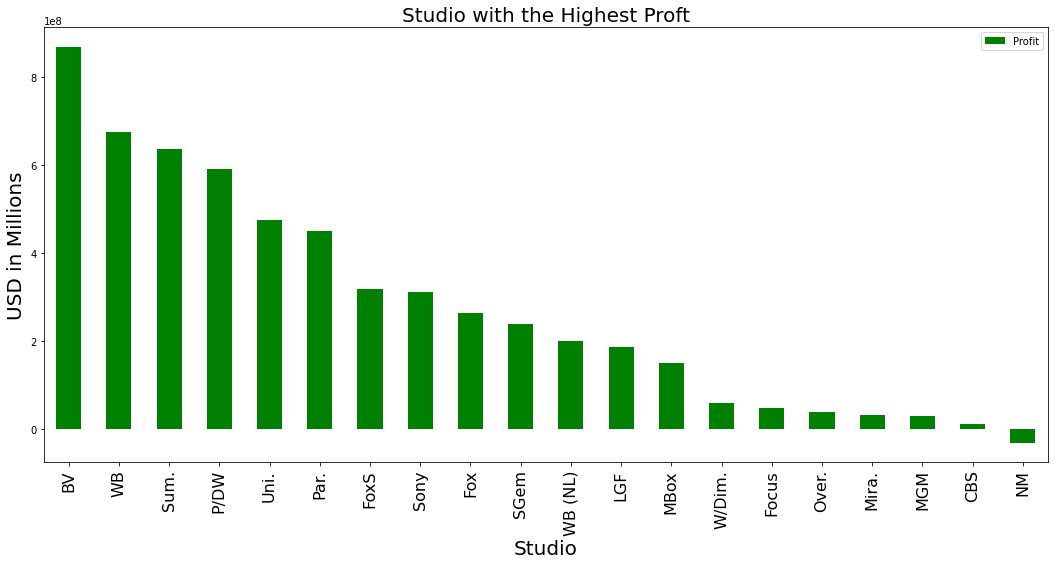

In [56]:
top_20_by_studio.plot("studio", kind="bar", figsize = (18,8), color = "g")
plt.xlabel("Studio", fontsize = 20)
plt.xticks(rotation = 90, fontsize=16)
plt.ylabel("USD in Millions", fontsize = 20)
plt.title("Studio with the Highest Proft", fontsize = 20)
plt.legend(labels=['Profit'])
plt.show()

In [57]:
bottom_20_by_studio = merged_gross_budget_and_genre_for_analysis[["studio","profit_or_loss"]].iloc[-20:]
bottom_20_by_studio.sort_values(by="profit_or_loss", ascending=True, inplace = True)

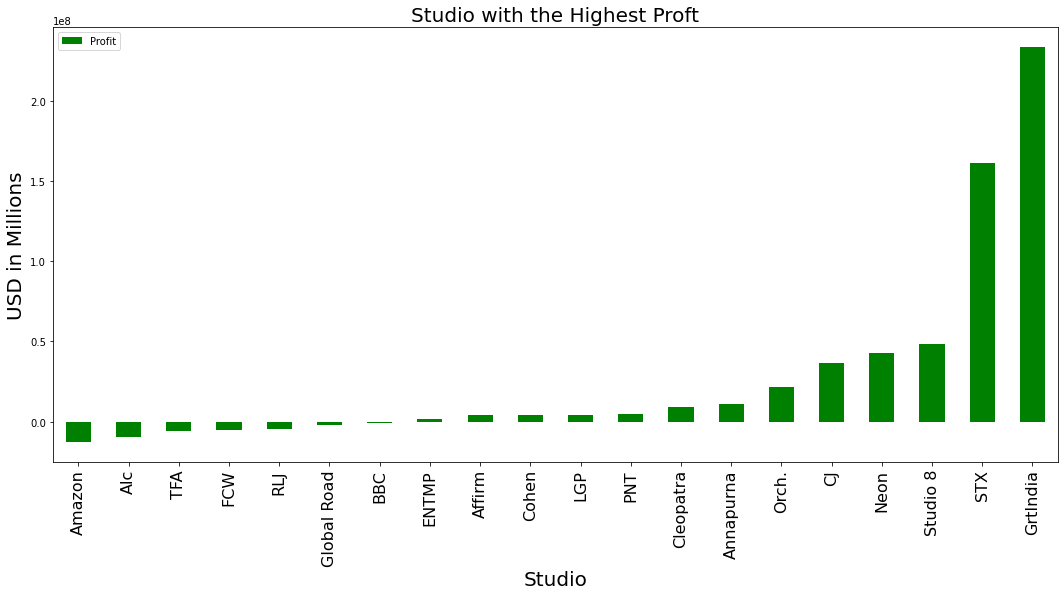

In [58]:
bottom_20_by_studio.plot("studio", kind="bar", figsize = (18,8), color = "g")
plt.xlabel("Studio", fontsize = 20)
plt.xticks(rotation = 90, fontsize=16)
plt.ylabel("USD in Millions", fontsize = 20)
plt.title("Studio with the Highest Proft", fontsize = 20)
plt.legend(labels=['Profit'])
plt.show()